# Encuentra la edad!

Basado en una foto, adivina la edad de la persona.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai as fai
import fastai.vision as fv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import numpy as np
from pathlib import Path
import random
import gc

## Los datos

En este caso usaremos el dataset "UTK faces", versión limpiada y aumentada por mi :) Si quieren, utilicen la [versión original](http://aicip.eecs.utk.edu/wiki/UTKFace). Probablemente les de *mejores* resultados que a mi. Yo la limpié para obtener mejores resultados a la hora de generar imágenes (luego veremos cómo), así que borré todas las caras borrosas, etc. Sin embargo, para adivinar edad, probablemente sea mejor no tomar solo las limpias, sino usar el dataset original.

In [3]:
path = Path('faces')

In [4]:
!ls {path} | head

0_0_4_3308.jpg
0_1_4_9032.jpg
100_0_0_20170112213500903.jpg
10_0_0_20161220222308131.jpg
10_0_0_20170103200329407.jpg
10_0_0_20170103200522151.jpg
10_0_0_20170103233459275.jpg
10_0_0_20170110215927291.jpg
10_0_0_20170110220033115.jpg
10_0_0_20170110220111082.jpg
ls: write error: Broken pipe


El primer número antes del _ es la edad. Vamos a crear una función para extraer la edad del nombre del archivo. Es útil conocer bien (o saber buscar) la biblioteca os y pathlib.

In [5]:
def extract_age(filename):
    return float(filename.stem.split('_')[0])

La manera de cargar datos es la usual. Vamos a:

- Crear un ImageItemList
- Partirlo en train/valid aleatoriamente, tomando 10% de los datos para valid. Cuidamos usar la misma semilla siempre.
- Las labels vienen de la función extract_age
- Lo demás es lo de siempre


In [6]:
def load_face_data(img_size, batch_size):
    tfms = fv.get_transforms()
    return (fv.ImageItemList.from_folder(path)
            .random_split_by_pct(0.1, seed=666)
            .label_from_func(extract_age, label_cls=fai.FloatList)
            .transform(tfms, size=img_size)
            .databunch(bs=batch_size))

In [7]:
#Las originales son de 200x200. No le veo caso subir a 224
data = load_face_data(192, 96) 

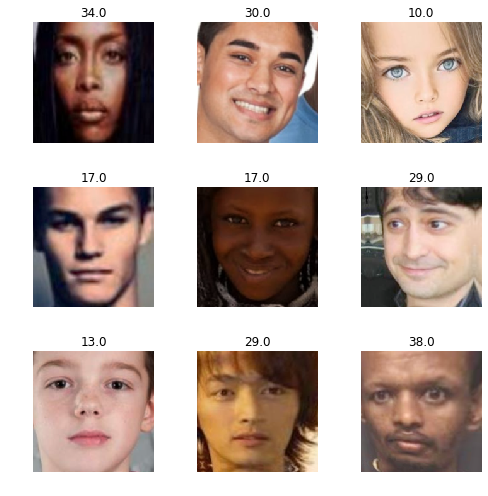

In [8]:
data.show_batch(rows=3, figsize=(7,7))

## Creando el Modelo

Esta vez no podemos ayudarnos de `create_cnn`, porque queremos hacer algunas cosas diferentes. Tendremos que crear el learner "a mano", y eso nos da oportunidad de hablar de los módulos de pytorch, los hijos, etc.

También nota que tomamos sigmoide y multiplicamos por 117. Esto es porque las edades van de 1 a 116, así que le ayudamos a la red neuronal a adivinar números en $(0,117)$.

In [9]:
class AgeModel(nn.Module):
    def __init__(self, filters, p = 0.33):
        super().__init__()
        ni = filters[0]
        layers = list(fv.models.resnet34(pretrained=True).children())[:-2]
        layers += [fai.AdaptiveConcatPool2d(), fai.Flatten()]
        
        for ni,no in zip(filters[:-1], filters[1:]):
            layers += [nn.LeakyReLU(),
                       nn.BatchNorm1d(ni),
                       nn.Dropout(p),
                       nn.Linear(ni,no)]
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        a = torch.sigmoid(self.net(x))*117
        # La siguiente línea me costó alrededor de 18 horas y varios posts en foros en donde nadie me ayudó :(
        return a.squeeze()

In [10]:
model = AgeModel([1024, 512, 16, 1])
#model.load_state_dict(torch.load("agestatedict.pth"))

### Creando el Aprendedor (Learner)

In [11]:
learn = fai.Learner(data, model, wd=0.1, loss_func=F.mse_loss)

Este error, F.mse_loss no está tan bien para esta aplicación en particular. Veremos cómo hacerlo mejor después.

Ahora, como no usamos `create_cnn`, fastai no sabe cómo "partir"  la red neuronal para saber cual es la parte entrenada, etc. Los números 3,6 y 8 los conseguí experimentando de la siguiente manera:

In [12]:
learn.split([model.net[3], model.net[6], model.net[8]])

In [13]:
learn.layer_groups[3] # cambia el 3 por 0, 1, 2 para ver qué son

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): AdaptiveMaxPool2d(output_size=1)
  (2): Lambda()
  (3): LeakyReLU(negative_slope=0.01)
  (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.33)
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.33)
  (10): Linear(in_features=512, out_features=16, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Dropout(p=0.33)
  (14): Linear(in_features=16, out_features=1, bias=True)
)

In [14]:
learn.freeze_to(-1)

In [15]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [96, 64, 96, 96]     9408       False     
______________________________________________________________________
BatchNorm2d          [96, 64, 96, 96]     128        True      
______________________________________________________________________
ReLU                 [96, 64, 96, 96]     0          False     
______________________________________________________________________
MaxPool2d            [96, 64, 48, 48]     0          False     
______________________________________________________________________
Conv2d               [96, 64, 48, 48]     36864      False     
______________________________________________________________________
BatchNorm2d          [96, 64, 48, 48]     128        True      
______________________________________________________________________
ReLU                 [96, 64, 48, 48]     0          False     
______________________________________________________________

## Entrenamiento

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


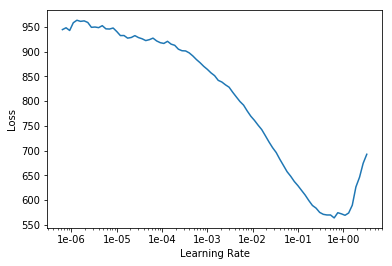

In [16]:
learn.lr_find(); learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3,.05) # super alta!!!

epoch,train_loss,valid_loss
1,144.766129,428.625244
2,123.994225,130.358780
3,90.145020,61.574368


Para entender el error promedio hay que sacar raiz cuadrada a esos números: (e.g. $\sqrt{64} = 8$, así que más o menos tenemos casi 8 años de error en la edad en promedio) 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


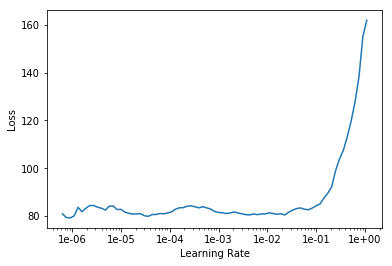

In [18]:
learn.lr_find(); learn.recorder.plot()

In [19]:
learn.fit_one_cycle(6,2e-3)

epoch,train_loss,valid_loss
1,79.445953,61.268936
2,80.242218,65.302528
3,77.003334,55.545780
4,74.370476,57.798595
5,71.598877,53.527050
6,71.559647,55.108929


In [20]:
learn.save('stage1')

In [24]:
learn.load('stage1');
gc.collect();

### Entrenamiento de las últimas capas

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


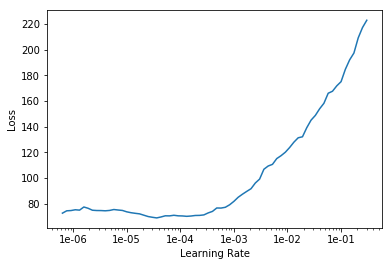

In [22]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [25]:
learn.fit_one_cycle(3, max_lr = slice(1e-5,1e-4))

epoch,train_loss,valid_loss
1,75.128723,55.288704
2,70.860199,52.467030
3,67.109169,48.866573


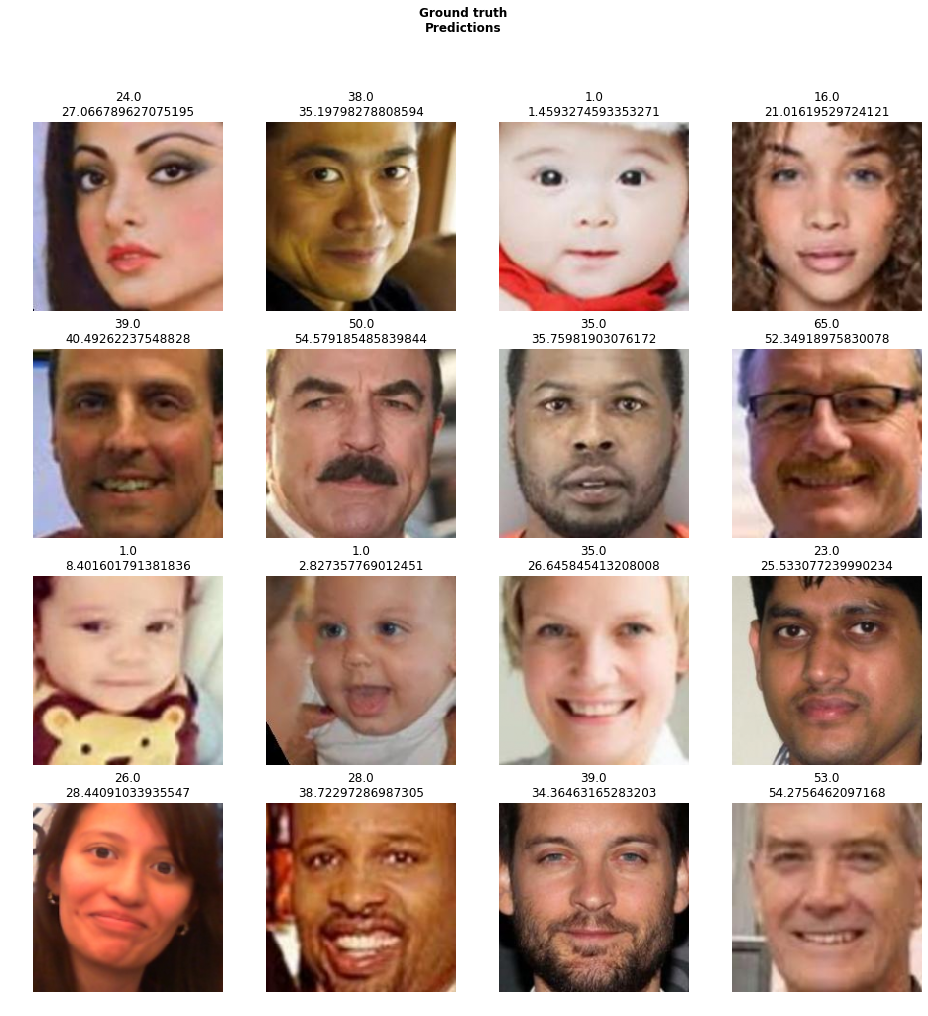

In [26]:
learn.show_results(rows=4)

In [27]:
learn.save('stage2')

## Loss

En realidad *no está muy bien* nuestra función de pérdida: Si alguien te muestra a su bebé recién nacido y dices: "ya tiene, qué, unos 5 años?" estás medio chiflado. 

PERO, si alguien tiene 65 años y adivinas 60... pues es razonable.

#### Mean Squared Error Loss:
Está definido así: $$\text{MSE}(a,b) = \frac{\left\lVert a-b\right\rVert^2}{n} = \frac{\left(a_1 - b_1\right)^2 + \dots + \left(a_n-b_n\right)^2}{n}$$

El problema de `mse_loss` es que le preocupa equivocarse por mucho en una (y no le preocupa equivocarse por poco en todas). Entonces con los bebés es conservador y trata de ponerles 4-5 años. No vaya a ser que se equivoque.

Una primera manera, que funciona bastante bien, es usar `l1_loss`. 

#### L1 Loss:

A MSE también se le conoce como L2 loss.

El `l1_loss` está definido asi: $$L_1(a,b) = \frac{\left|a_1 - b_1\right| + \dots + \left|a_n-b_n\right|}{n}$$

In [28]:
learn.loss_func = F.l1_loss

In [29]:
gc.collect()

29434

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


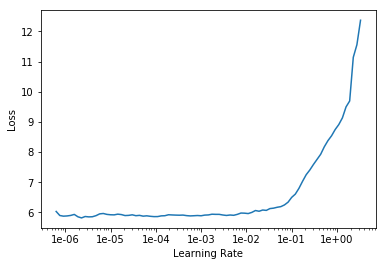

In [30]:
learn.freeze()
learn.lr_find(); learn.recorder.plot()

In [31]:
learn.fit_one_cycle(2,3e-3)

epoch,train_loss,valid_loss
1,6.201625,5.003107
2,6.007763,5.007272


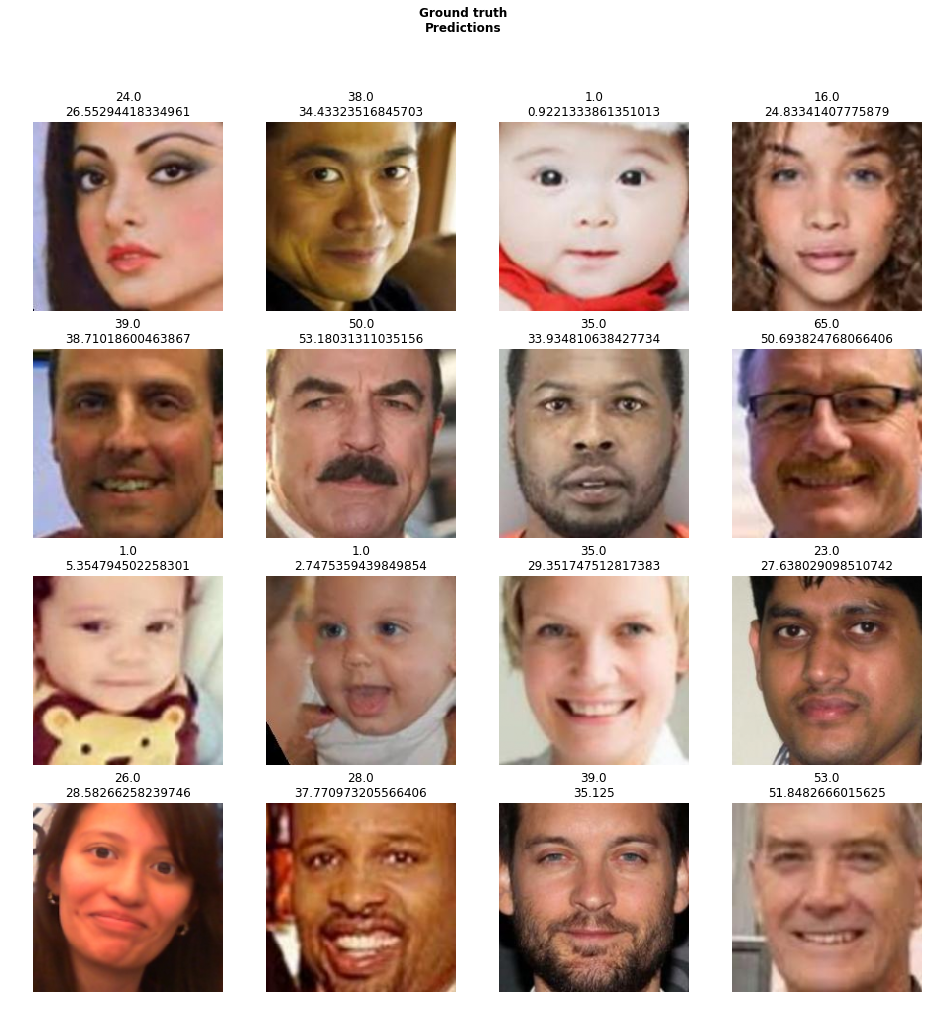

In [32]:
learn.show_results(rows=4)

In [33]:
learn.save('stage1-L1')

#### ¿Cómo inventamos una loss function mejor?

L1 ya funciona bastante bien. Pero imaginemos que queremos una función de pérdida que exprese mejor lo que queremos: que la *diferencia entre valores pequeños sea grande*, pero la *diferencia entre valores grandes sea chica*. 

Para obtener esto, debemos aplicar una función convexa *antes de hacer la diferencia*:
![función convexa](concavefunc.png)

Entonces, por ejemplo, podríamos tomar:
$$f(a,b) = \left(\sqrt{a_1}-\sqrt{b_1}\right)^2 + \dots +  \left(\sqrt{a_n}-\sqrt{b_n}\right)^2$$

Algo muy común es tomar el logaritmo

In [ ]:
def age_loss(pred,targ):
    return F.mse_loss(torch.log(pred),torch.log(targ))

De esta manera, estaríamos pensando que equivocarse de 2 a 3 es equivalente a equivocarse de 40 a 60 (es en porcentaje). Quizás lo que queremos no es taaan extremo!

A mi me suena que equivocarme de 2 a 3 años sería más o menos equivalente a equivocarse entre 40 y 46 años. Estuve experimentando, y algo así me suena bien:

In [39]:
def age_loss(pred,targ):
    a = 0.3
    p = (1+pred)**a
    t = (1+targ)**a
    return F.l1_loss(p,t)

In [40]:
def age_compare(a, b): 
    return age_loss(torch.tensor(float(a)), torch.tensor(float(b))).item()

In [41]:
age_compare(2,3), age_compare(15,18), age_compare(40,46), age_compare(60, 68), age_compare(90, 100)

(0.12532734870910645,
 0.12154865264892578,
 0.1274256706237793,
 0.12927031517028809,
 0.12296032905578613)

In [42]:
learn.loss_func = age_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


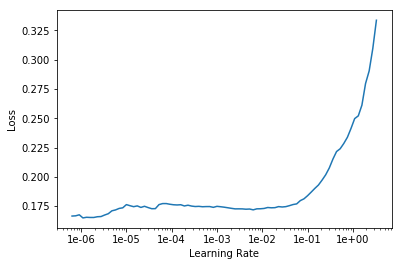

In [43]:
learn.freeze()
learn.lr_find(); learn.recorder.plot()

In [44]:
learn.fit_one_cycle(4, 2e-3)

epoch,train_loss,valid_loss
1,0.174999,0.141672
2,0.169791,0.132381
3,0.168966,0.133146
4,0.166328,0.133320


In [45]:
learn.save('stage1-customloss')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


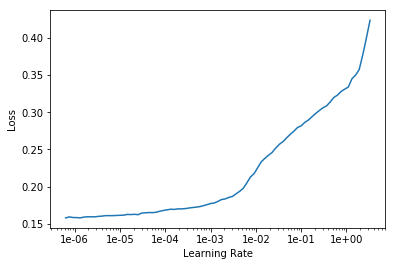

In [46]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [47]:
learn.fit_one_cycle(4,slice(1e-5,1e-4))

epoch,train_loss,valid_loss
1,0.168454,0.141585
2,0.166469,0.134397
3,0.163721,0.130991
4,0.160442,0.126697


Esta función de error es un poco más lenta de calcular!! Entonces de hecho nuestro entrenamiento con MSE y L1 sirvió bastante, como para llegar a un estimado, y luego ya ajustamos con la loss function que nos interesa.

Esta idea de cambiar la loss function por algo más sencillo es importante para entrenar rápido y bien. Lo veremos más cuando veamos GANs y Autoencoders.

In [48]:
learn.save('stage2-customloss')

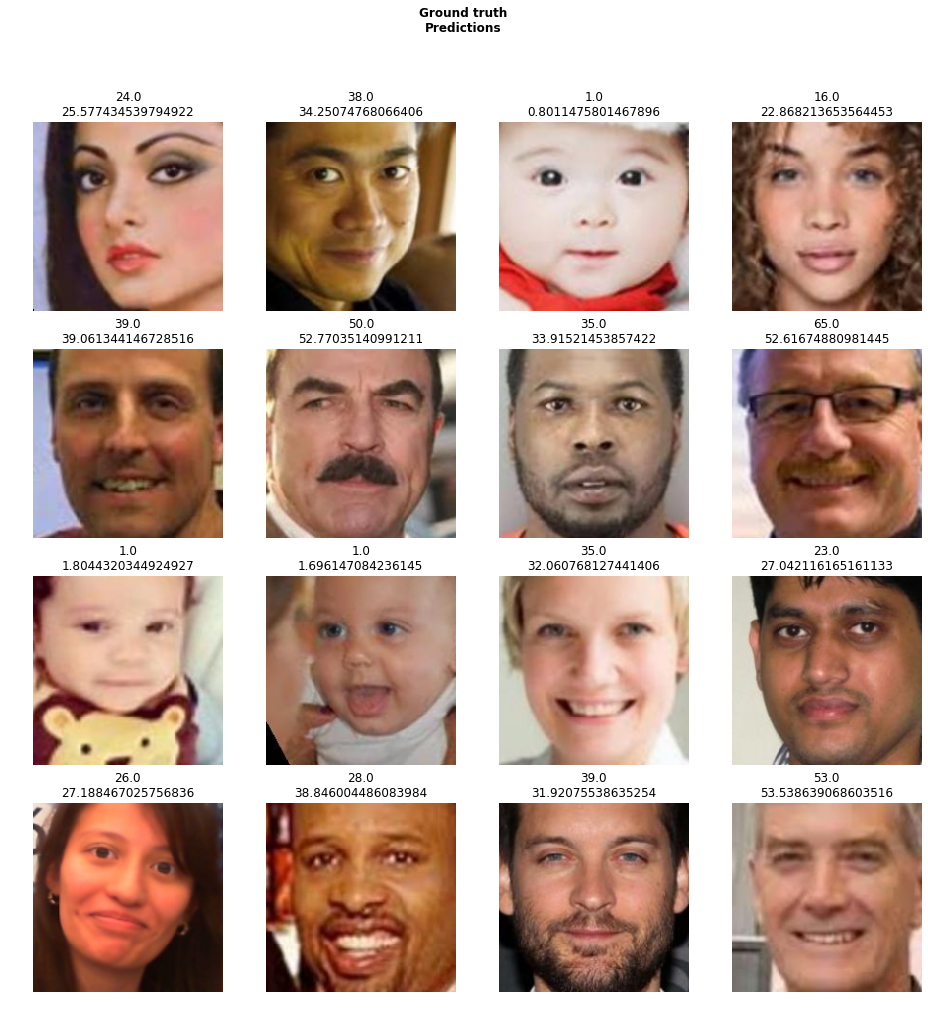

In [49]:
learn.show_results(rows=4)

Qué razonable!!

# Fin